In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk
from transformers import AutoTokenizer

import json
import os
from datasets import Dataset

/home/wuhyun/competition/ODQA/QDQA_0.1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 시각화 스타일 설정
plt.style.use('seaborn-v0_8')
plt.rc('font', family='NanumBarunGothic') # 한글 폰트 설정 (환경에 맞게 변경)
plt.rcParams['axes.unicode_minus'] = False

In [3]:
data_path = "../raw/data/"

train_path = "train_dataset/train/dataset.arrow"
vaild_path = "train_dataset/validation/dataset.arrow"
test_path = "test_dataset/validation/dataset.arrow"
docs_path = "wikipedia_documents.json"


# 단일 arrow 파일 로드
train_df = Dataset.from_file(os.path.join(data_path, train_path))
test_df = Dataset.from_file(os.path.join(data_path, test_path))

# Pandas DataFrame으로 변환
train_df = train_df.to_pandas()
test_df = test_df.to_pandas()

In [4]:
vaildation_df = Dataset.from_file(os.path.join(data_path, vaild_path))

In [5]:
vaildation_df

Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 240
})

In [6]:
load_from_disk("../raw/data/train_dataset"), load_from_disk("../raw/data/test_dataset")

(DatasetDict({
     train: Dataset({
         features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
         num_rows: 3952
     })
     validation: Dataset({
         features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
         num_rows: 240
     })
 }),
 DatasetDict({
     validation: Dataset({
         features: ['question', 'id'],
         num_rows: 600
     })
 }))

In [7]:
print(f"Train Size: {len(train_df)}")
print(f"Test Size: {len(test_df)}")

Train Size: 3952
Test Size: 600


In [8]:
def process_answers(row):
    if 'answers' in row and row['answers']:
        # Arrow 데이터셋 로드 시 딕셔너리 구조가 유지되는 경우와 그렇지 않은 경우 처리
        ans = row['answers']
        text = ans['text'][0] if len(ans['text']) > 0 else ""
        start = ans['answer_start'][0] if len(ans['answer_start']) > 0 else 0
        return text, start
    return None, None

# Train 데이터에만 정답 컬럼 생성
train_df[['answer_text', 'answer_start']] = train_df.apply(process_answers, axis=1, result_type='expand')


토큰화 진행 중...


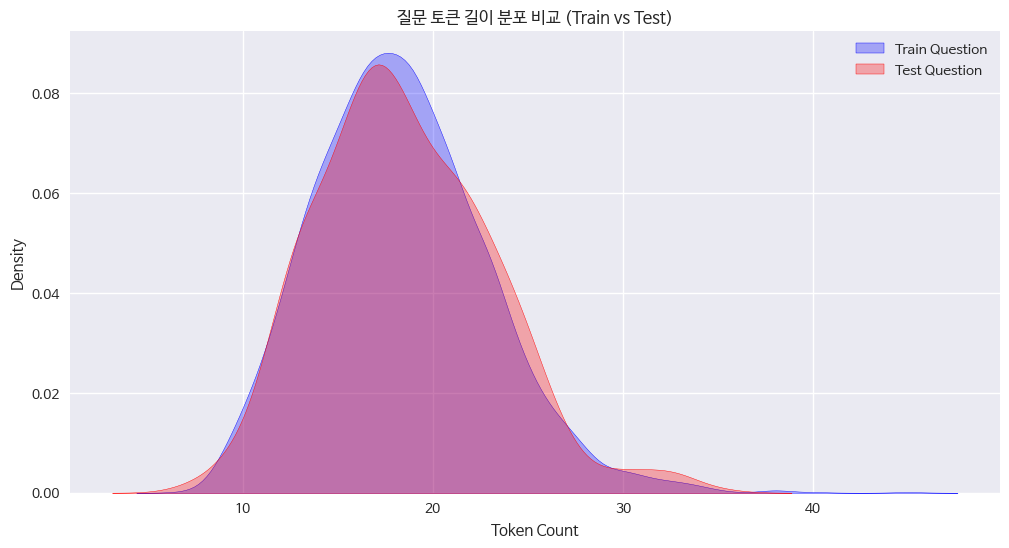

Train Question Mean Length: 18.30
Test Question Mean Length:  18.49


In [9]:
model_name = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("\n토큰화 진행 중...")
train_df['q_len'] = train_df['question'].apply(lambda x: len(tokenizer.encode(x)))
test_df['q_len'] = test_df['question'].apply(lambda x: len(tokenizer.encode(x)))

plt.figure(figsize=(12, 6))
sns.kdeplot(train_df['q_len'], fill=True, label='Train Question', color='blue', alpha=0.3)
sns.kdeplot(test_df['q_len'], fill=True, label='Test Question', color='red', alpha=0.3)
plt.title("질문 토큰 길이 분포 비교 (Train vs Test)")
plt.xlabel("Token Count")
plt.legend()
plt.show()

print(f"Train Question Mean Length: {train_df['q_len'].mean():.2f}")
print(f"Test Question Mean Length:  {test_df['q_len'].mean():.2f}")

<Figure size 1400x600 with 0 Axes>

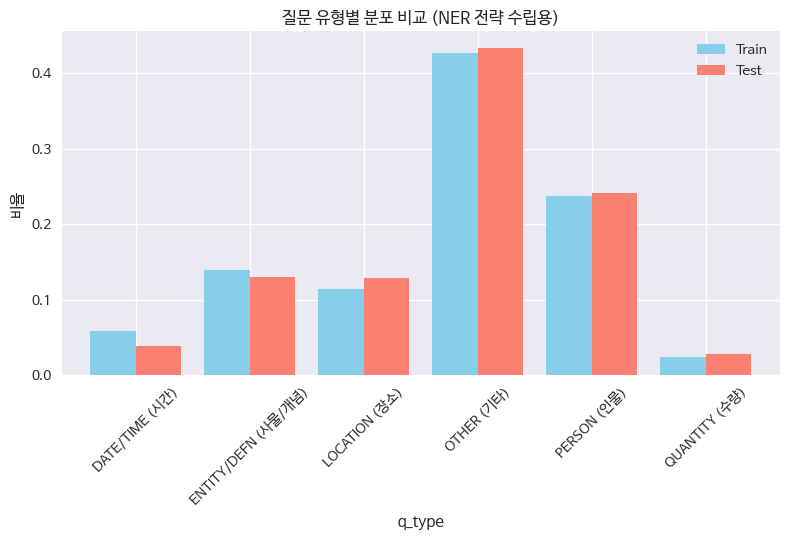

In [10]:
def check_question_type(text):
    if any(x in text for x in ['누구', '인물', '사람', '배우', '작가', '대상']):
        return 'PERSON (인물)'
    elif any(x in text for x in ['언제', '년도', '날짜', '시간', '기간', '며칠']):
        return 'DATE/TIME (시간)'
    elif any(x in text for x in ['어디', '장소', '국가', '도시', '위치', '곳은']):
        return 'LOCATION (장소)'
    elif any(x in text for x in ['몇', '얼마', '개수', '수량']):
        return 'QUANTITY (수량)'
    elif any(x in text for x in ['무엇', '어떤', '무슨', '뜻', '의미']):
        return 'ENTITY/DEFN (사물/개념)'
    else:
        return 'OTHER (기타)'

train_df['q_type'] = train_df['question'].apply(check_question_type)
test_df['q_type'] = test_df['question'].apply(check_question_type)

# 비율 계산
train_type_counts = train_df['q_type'].value_counts(normalize=True).sort_index()
test_type_counts = test_df['q_type'].value_counts(normalize=True).sort_index()

# 시각화
comp_df = pd.DataFrame({'Train': train_type_counts, 'Test': test_type_counts})

plt.figure(figsize=(14, 6))
comp_df.plot(kind='bar', width=0.8, color=['skyblue', 'salmon'])
plt.title("질문 유형별 분포 비교 (NER 전략 수립용)")
plt.ylabel("비율")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
from collections import Counter

def get_nouns(text_list):
    words = []
    for text in text_list:
        # 간단하게 조사 제거 등을 하지 않고 어절 단위로 카운트 (빠른 확인용)
        # 실제로는 Mecab 등을 쓰는게 좋음
        words.extend(text.split())
    return words

train_words = get_nouns(train_df['question'])
test_words = get_nouns(test_df['question'])

train_counter = Counter(train_words).most_common(20)
test_counter = Counter(test_words).most_common(20)

print("\n=== Train 질문 주요 키워드 ===")
print([w[0] for w in train_counter])

print("\n=== Test 질문 주요 키워드 ===")
print([w[0] for w in test_counter])


=== Train 질문 주요 키워드 ===
['사람은?', '인물은?', '것은?', '있는', '수', '어떤', '위해', '것은', '무엇인가?', '누구인가?', '된', '해는?', '곳은?', '어느', '중', '한', '몇', '가장', '무엇을', '이름은?']

=== Test 질문 주요 키워드 ===
['사람은?', '것은?', '인물은?', '위해', '수', '곳은?', '어떤', '한', '무엇인가?', '해는?', '어느', '누구인가?', '있는', '것은', '몇', '된', '대한', '중', '있는가?', '이름은?']


In [12]:
print("\n" + "="*50)
print("🚀 [분석 결론 및 전략 가이드]")
print("="*50)

# 1. 길이 분석 결과에 따른 전략
diff = abs(train_df['q_len'].mean() - test_df['q_len'].mean())
if diff > 5:
    print(f"- 주의: Train과 Test의 질문 길이 차이가 큽니다 ({diff:.2f} tokens).")
    print("  Test 질문이 더 길다면 Retriever 검색 시 쿼리 확장을 고려하세요.")
else:
    print("- 양호: Train과 Test의 질문 길이가 비슷합니다.")

# 2. 질문 유형 분석 결과에 따른 전략 (NER)
top_test_type = test_type_counts.idxmax()
print(f"- Test 데이터에서 가장 많은 질문 유형은 '{top_test_type}' 입니다.")

if 'PERSON' in top_test_type or 'LOCATION' in top_test_type:
    print("  👉 전략: 인물(PER)과 장소(LOC)를 인식하는 NER 모델을 후처리 필터로 반드시 사용하세요.")
    print("  👉 예: 질문에 '누구'가 있으면 답변 후보 중 PER 태그가 없는 것은 감점.")

if 'DATE' in top_test_type or 'QUANTITY' in top_test_type:
    print("  👉 전략: 숫자 정규화(Normalization)와 정규표현식 매칭이 중요합니다.")
    print("  👉 예: '1999년'과 '99년'을 같게 처리하거나, 숫자 답변에 가산점 부여.")

print("="*50)


🚀 [분석 결론 및 전략 가이드]
- 양호: Train과 Test의 질문 길이가 비슷합니다.
- Test 데이터에서 가장 많은 질문 유형은 'OTHER (기타)' 입니다.


In [13]:
with open(os.path.join(data_path, docs_path), "r", encoding="utf-8") as f:
    wiki: dict = json.load(f)
    print(wiki['0'])

{'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.', 'corpus_source': '위키피디아', 'url': 'TODO', 'domain': None, 'title': '나라 목록', 'author': None, 'html': None, 'document_id': 0}


In [14]:
wiki_df = pd.DataFrame.from_dict(wiki, orient='index')

In [15]:
wiki_df.head(5)

,text,corpus_source,url,domain,title,author,html,document_id
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4


In [16]:
pd.set_option('display.max_columns', None)

In [17]:
train_df.head(5)

,title,context,question,id,answers,document_id,__index_level_0__,answer_text,answer_start,q_len,q_type
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,"{'answer_start': [235], 'text': ['하원']}",18293,42,하원,235,18,LOCATION (장소)
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,"{'answer_start': [212], 'text': ['《경영의 실제》']}",51638,2873,《경영의 실제》,212,15,OTHER (기타)
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,"{'answer_start': [510], 'text': ['백성']}",5028,230,백성,510,20,PERSON (인물)
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,"{'answer_start': [625], 'text': ['중국']}",34146,992,중국,625,25,ENTITY/DEFN (사물/개념)
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,"{'answer_start': [30], 'text': ['4개']}",47334,548,4개,30,16,QUANTITY (수량)


In [18]:
test_df.head(5)

,question,id,q_len,q_type
0,유령'은 어느 행성에서 지구로 왔는가?,mrc-1-000653,14,OTHER (기타)
1,용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?,mrc-1-001113,19,ENTITY/DEFN (사물/개념)
2,돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?,mrc-0-002191,25,PERSON (인물)
3,"마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?",mrc-0-003951,21,OTHER (기타)
4,디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?,mrc-1-001272,18,LOCATION (장소)


In [19]:
import random

queries_size = len(train_df)

random_indices = random.sample(range(queries_size), 5)
queries = train_df.iloc[random_indices]['question']

In [20]:
wikis = wiki_df
titles = wikis['title'].tolist()
texts = wikis['text'].tolist()

### 아래 내용은 테스트이므로, 무시

In [21]:
# from rank_bm25 import BM25Okapi
# from kiwipiepy import Kiwi

# kiwi = Kiwi()

# def kiwi_tokenizer(text: str) -> list[str]:
#     """
#     형태소의 품사가 명사, 동사, 형용사, 숫자, 외국어, 한자 등인 형태소만 추출

#     Args:
#         text (str): 원본 text

#     Returns:
#         list[str]: 추출된 형태소 Tokens
#     """
#     tokens = kiwi.tokenize(text)
#     return [
#         t.form
#         for t in tokens
#         if t.tag.startswith("N")
#         or t.tag.startswith("V")
#         or t.tag.startswith("SN")
#         or t.tag.startswith("SL")
#         or t.tag.startswith("SH")
#     ]

# tokenized_corpus = [
#     kiwi_tokenizer(tit + " " + txt)
#     for tit, txt in zip(titles, texts)
# ]
# bm25 = BM25Okapi(corpus=tokenized_corpus)

In [22]:
tokenized_corpus

NameError: name 'tokenized_corpus' is not defined

In [29]:
for elem in train_df['answers'].apply(lambda x:x['text']).values:
    if len(elem) > 1:
        print("?")

In [ ]:
from tqdm import tqdm

print("Sparse 검색 중...")
bm25_scores_list = []
bm25_indices_list = []
topk = 10

for query in tqdm(queries, desc="BM25"):
    tokenized_query = kiwi_tokenizer(query)
    scores = bm25.get_scores(tokenized_query)

    # Top-k 인덱스만 뽑아옵니다.
    topk_indices = np.argsort(scores)[::-1][:topk]
    bm25_scores_list.append(scores[topk_indices])
    bm25_indices_list.append(topk_indices)

In [ ]:
bm25_scores_list

In [ ]:
d = {1: 23.3, 2: 21.2, 3:43.1}
sorted(d.items(), key=lambda x: x[1], reverse=True)